In [1]:
import tensorflow as tf
import numpy as np
from tensorflow_graphics.geometry.transformation import quaternion as quat
import matplotlib.pyplot as plt

In [2]:
# Load data
joints_file = open('joints_quat_values.npy', 'rb')
ee_file = open('ee_quat_poses.npy', 'rb')
joints_data = np.load(joints_file)
ee_data = np.load(ee_file)
joints_file.close()
ee_file.close()

In [3]:
print(joints_data[0])
print(ee_data[0])

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
[0. 0. 3. 0. 0. 0. 1.]


In [4]:
dataset = tf.data.Dataset.from_tensor_slices((ee_data, joints_data)).prefetch(1)
DATASET_SIZE = len(dataset)
train_size = int(0.8*DATASET_SIZE)
val_size = int(0.1*DATASET_SIZE)
test_size = int(0.1*DATASET_SIZE)

print(f'DATASET_SIZE={DATASET_SIZE}')
print(list(dataset.take(1).as_numpy_iterator()))
print(train_size, val_size, test_size)

DATASET_SIZE=160000
[(array([0., 0., 3., 0., 0., 0., 1.]), array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]]))]
128000 16000 16000


In [5]:
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size).skip(val_size)

print(len(train_ds), len(val_ds), len(test_ds))

128000 16000 16000


In [6]:
BATCH_SIZE = 8

# flatten the target_y results
train_batches = train_ds.shuffle(train_size//4).map(lambda x,y: (x,tf.reshape(y, [-1]))).batch(BATCH_SIZE).prefetch(1)
train_val = val_ds.map(lambda x,y: (x,tf.reshape(y, [-1]))).batch(BATCH_SIZE).prefetch(1) # does not shuffling since we do not backpropagate here

In [7]:
print(train_batches.as_numpy_iterator().next()[0].shape) # input
print(train_batches.as_numpy_iterator().next()[1].shape) # target
print(train_batches.as_numpy_iterator().next()[1]) # target sample

(8, 7)
(8, 16)
[[ 0.          0.          0.32473039  0.94579662  0.94579662  0.
   0.          0.32473039  0.          0.87945295  0.          0.47609275
   0.          0.          0.          1.        ]
 [ 0.          0.          0.47609275  0.87945295  0.91576364  0.
   0.          0.40176297  0.          0.47609275  0.          0.87945295
   0.          0.         -0.16459912  0.98635713]
 [ 0.          0.          0.32473039  0.94579662  0.98635713  0.
   0.          0.16459912  0.          1.          0.          0.
   0.          0.          0.96937984 -0.24543015]
 [ 0.          0.          0.16459912  0.98635713  0.          0.
   0.          1.          0.          0.08255806  0.          0.99657617
   0.          0.          0.          1.        ]
 [ 0.          0.          0.32473039  0.94579662  0.24543015  0.
   0.          0.96937984  0.          0.54710928  0.          0.83714136
   0.          0.         -0.16459912  0.98635713]
 [ 0.          0.          0.32473039 

In [8]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(7,), batch_size=BATCH_SIZE),
        tf.keras.layers.Dense(256, activation='relu', batch_size=BATCH_SIZE),
        tf.keras.layers.Dense(164, activation='relu'),
        tf.keras.layers.Dense(16, name='joints_values')
    ])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (8, 256)                  2048      
_________________________________________________________________
dense_1 (Dense)              (8, 164)                  42148     
_________________________________________________________________
joints_values (Dense)        (8, 16)                   2640      
Total params: 46,836
Trainable params: 46,836
Non-trainable params: 0
_________________________________________________________________


In [9]:
epochs=24
init_lr = 1e-3
# optimizer = tf.keras.optimizers.Adam(lr=init_lr)
optimizer = tf.keras.optimizers.SGD(lr=init_lr, momentum=0.9)

model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()])


history = model.fit(train_batches, validation_data=train_val, epochs=epochs)

/home/juancm/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/24
16000/16000 [==============================] - 8s 497us/step - loss: 0.0801 - mean_squared_error: 0.0801 - val_loss: 0.0675 - val_mean_squared_error: 0.0675
Epoch 2/24
16000/16000 [==============================] - 8s 499us/step - loss: 0.0664 - mean_squared_error: 0.0664 - val_loss: 0.0588 - val_mean_squared_error: 0.0588
Epoch 3/24
16000/16000 [==============================] - 8s 475us/step - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0591 - val_mean_squared_error: 0.0591
Epoch 4/24
16000/16000 [==============================] - 8s 487us/step - loss: 0.0616 - mean_squared_error: 0.0616 - val_loss: 0.0573 - val_mean_squared_error: 0.0573
Epoch 5/24
16000/16000 [==============================] - 8s 482us/step - loss: 0.0605 - mean_squared_error: 0.0605 - val_loss: 0.0579 - val_mean_squared_error: 0.0579
Epoch 6/24
16000/16000 [==============================] - 8s 481us/step - loss: 0.0596 - mean_squared_error: 0.0596 - val_loss: 0.0578 - val_mean_squared_error:

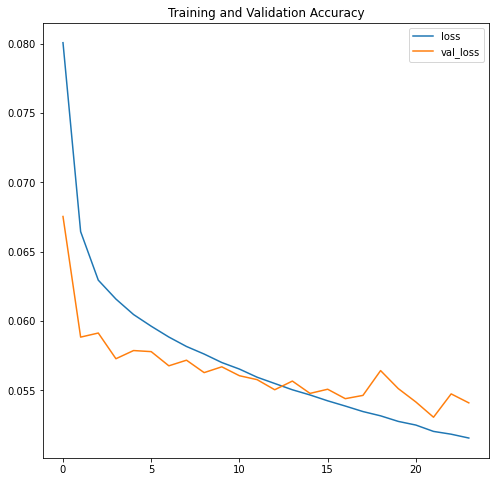

In [10]:
# metric_loss = history.history['mean_squared_error']
# val_metric_loss = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, metric_loss, label='mean_squared_error')
# plt.plot(epochs_range, val_metric_loss, label='val_mean_squared_error')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Accuracy')

plt.show()

In [11]:
ds = test_ds.map(lambda x,y: (x,tf.reshape(y, [-1]))).batch(BATCH_SIZE).prefetch(1)
results = model.evaluate(ds, batch_size=8)
model.predict(ds.take(1).take(1))

2000/2000 [==============================] - 1s 297us/step - loss: 0.0625 - mean_squared_error: 0.0625


array([[ 3.7373576e-02, -3.9637182e-02,  7.0232987e-02,  4.3071079e-01,
        -8.5403174e-02, -4.1087739e-02, -3.2631360e-02,  1.1135972e+00,
         8.6684562e-03, -2.7606785e-02, -6.1814860e-04,  1.0419230e+00,
        -4.2820573e-03, -3.3007134e-03,  4.8068994e-01,  3.9144886e-01],
       [ 3.9743796e-02, -4.5700733e-02,  8.3088890e-02,  4.0323237e-01,
        -1.2774923e-01, -3.6703303e-02, -3.6192849e-02,  1.1398855e+00,
         5.6248708e-03, -3.8769901e-02,  2.2472590e-03,  1.0489763e+00,
        -2.1893075e-02,  1.1898150e-02,  4.8323774e-01,  4.0685129e-01],
       [ 3.8059510e-02, -4.3917872e-02,  1.0006071e-01,  3.8728601e-01,
        -1.4020380e-01, -2.5171636e-02, -3.7807524e-02,  1.1464878e+00,
         7.1459822e-04, -4.9438864e-02, -3.2880493e-03,  1.0651962e+00,
        -2.4275644e-02,  2.5202785e-02,  4.9139935e-01,  3.8981679e-01],
       [ 2.9353317e-02, -3.6231946e-02,  1.5474424e-01,  3.5748065e-01,
        -1.5844163e-01, -1.1206562e-02, -2.3492457e-02,  1.14

In [12]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(7,), batch_size=BATCH_SIZE),
        tf.keras.layers.Dense(256, activation='relu', batch_size=BATCH_SIZE),
        tf.keras.layers.Dense(164, activation='relu'),
        tf.keras.layers.Dense(16, name='joints_values')
    ])
    return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (8, 256)                  2048      
_________________________________________________________________
dense_3 (Dense)              (8, 164)                  42148     
_________________________________________________________________
joints_values (Dense)        (8, 16)                   2640      
Total params: 46,836
Trainable params: 46,836
Non-trainable params: 0
_________________________________________________________________


In [13]:
epochs=24
init_lr = 1e-4
# optimizer = tf.keras.optimizers.Adam(lr=init_lr)
optimizer = tf.keras.optimizers.SGD(lr=init_lr, momentum=0.9)

model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()])


history = model.fit(train_batches, validation_data=train_val, epochs=epochs)

/home/juancm/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/24
16000/16000 [==============================] - 8s 490us/step - loss: 0.1105 - mean_squared_error: 0.1105 - val_loss: 0.0918 - val_mean_squared_error: 0.0918
Epoch 2/24
16000/16000 [==============================] - 8s 483us/step - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.0874 - val_mean_squared_error: 0.0874
Epoch 3/24
16000/16000 [==============================] - 8s 485us/step - loss: 0.0862 - mean_squared_error: 0.0862 - val_loss: 0.0838 - val_mean_squared_error: 0.0838
Epoch 4/24
16000/16000 [==============================] - 8s 480us/step - loss: 0.0835 - mean_squared_error: 0.0835 - val_loss: 0.0813 - val_mean_squared_error: 0.0813
Epoch 5/24
16000/16000 [==============================] - 8s 475us/step - loss: 0.0810 - mean_squared_error: 0.0810 - val_loss: 0.0787 - val_mean_squared_error: 0.0787
Epoch 6/24
16000/16000 [==============================] - 8s 487us/step - loss: 0.0790 - mean_squared_error: 0.0790 - val_loss: 0.0764 - val_mean_squared_error:

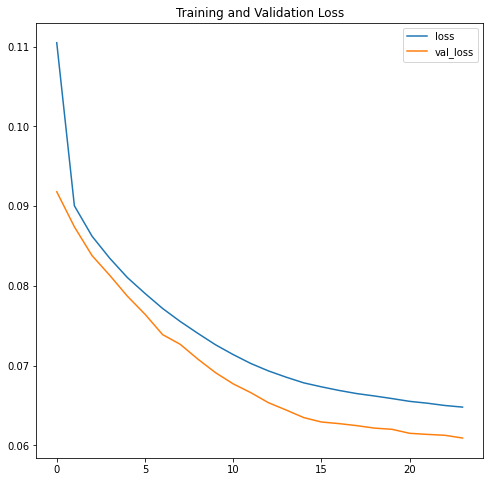

In [14]:
# metric_loss = history.history['mean_squared_error']
# val_metric_loss = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, metric_loss, label='mean_squared_error')
# plt.plot(epochs_range, val_metric_loss, label='val_mean_squared_error')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Accuracy')

plt.show()

In [15]:
ds = test_ds.map(lambda x,y: (x,tf.reshape(y, [-1]))).batch(BATCH_SIZE).prefetch(1)
results = model.evaluate(ds, batch_size=8)
model.predict(ds.take(1).take(1))

2000/2000 [==============================] - 1s 288us/step - loss: 0.0588 - mean_squared_error: 0.0588


array([[ 4.5932215e-02, -2.7179487e-02, -4.7771525e-02,  4.9070412e-01,
         2.8331113e-01,  5.3820182e-02, -2.7294211e-02,  8.5120517e-01,
        -2.0682670e-02,  2.1765481e-01, -2.6942786e-02,  9.7506350e-01,
        -3.4870036e-02,  2.3599859e-02,  3.2786387e-01,  5.8671314e-01],
       [ 4.9476631e-02, -3.2252718e-02, -4.5311827e-02,  4.6885395e-01,
         2.7856356e-01,  5.7952765e-02, -2.4485275e-02,  8.5229647e-01,
        -2.9522516e-02,  2.1846288e-01, -1.9336015e-02,  9.7443265e-01,
        -2.5428368e-02,  1.7902520e-02,  3.1860209e-01,  5.7874447e-01],
       [ 4.8308246e-02, -3.8442705e-02, -5.3074669e-02,  4.4903314e-01,
         2.7421823e-01,  5.9895936e-02, -2.1025434e-02,  8.4899503e-01,
        -3.4207918e-02,  2.1654506e-01, -1.4388030e-02,  9.7009462e-01,
        -1.0631161e-02,  9.7432239e-03,  3.0517241e-01,  5.6221020e-01],
       [ 3.8748693e-02, -5.1248953e-02, -5.0670829e-02,  4.3125576e-01,
         2.7550322e-01,  5.1542845e-02, -1.0765059e-02,  8.40

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(7,), batch_size=BATCH_SIZE),
        tf.keras.layers.Dense(256, activation='relu', batch_size=BATCH_SIZE),
        tf.keras.layers.Dense(164, activation='relu'),
        tf.keras.layers.Dense(16, name='joints_values')
    ])
    return model

model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (8, 256)                  2048      
_________________________________________________________________
dense_5 (Dense)              (8, 164)                  42148     
_________________________________________________________________
joints_values (Dense)        (8, 16)                   2640      
Total params: 46,836
Trainable params: 46,836
Non-trainable params: 0
_________________________________________________________________


In [17]:
epochs=24
init_lr = 1e-2
# optimizer = tf.keras.optimizers.Adam(lr=init_lr)
optimizer = tf.keras.optimizers.SGD(lr=init_lr, momentum=0.9)

model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()])


history = model.fit(train_batches, validation_data=train_val, epochs=epochs)

Epoch 1/24
16000/16000 [==============================] - 8s 472us/step - loss: 0.0590 - mean_squared_error: 0.0590 - val_loss: 0.0549 - val_mean_squared_error: 0.0549
Epoch 2/24
16000/16000 [==============================] - 8s 480us/step - loss: 0.0532 - mean_squared_error: 0.0532 - val_loss: 0.0543 - val_mean_squared_error: 0.0543
Epoch 3/24
16000/16000 [==============================] - 8s 481us/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.0534 - val_mean_squared_error: 0.0534
Epoch 4/24
16000/16000 [==============================] - 8s 486us/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0522 - val_mean_squared_error: 0.0522
Epoch 5/24
16000/16000 [==============================] - 8s 474us/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 0.0523 - val_mean_squared_error: 0.0523
Epoch 6/24
16000/16000 [==============================] - 8s 470us/step - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0535 - val_mean_squared_error:

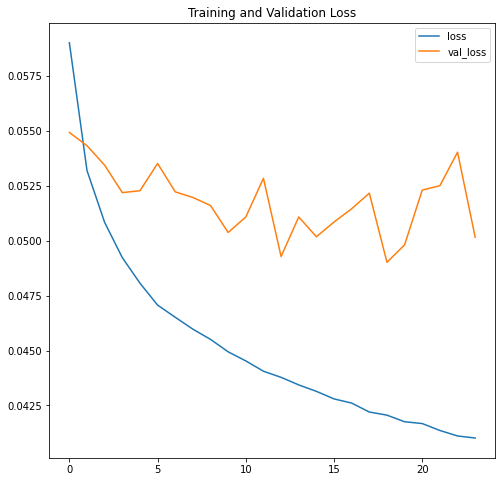

In [18]:
# metric_loss = history.history['mean_squared_error']
# val_metric_loss = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, metric_loss, label='mean_squared_error')
# plt.plot(epochs_range, val_metric_loss, label='val_mean_squared_error')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Accuracy')

plt.show()

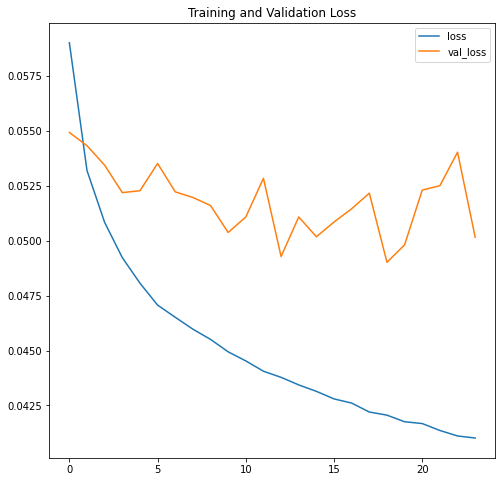

In [19]:
# metric_loss = history.history['mean_squared_error']
# val_metric_loss = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, metric_loss, label='mean_squared_error')
# plt.plot(epochs_range, val_metric_loss, label='val_mean_squared_error')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Accuracy')

plt.show()

In [20]:
ds = test_ds.map(lambda x,y: (x,tf.reshape(y, [-1]))).batch(BATCH_SIZE).prefetch(1)
results = model.evaluate(ds, batch_size=8)
model.predict(ds.take(1).take(1))

2000/2000 [==============================] - 1s 276us/step - loss: 0.0650 - mean_squared_error: 0.0650


array([[-2.1777260e-03,  6.1246012e-03,  2.1147567e-01,  3.5982823e-01,
        -7.2481096e-02,  1.2559451e-03, -2.2982908e-03,  1.0851163e+00,
        -2.3322853e-03, -1.7600030e-02,  1.5983442e-03,  1.0952950e+00,
         1.9649996e-03,  1.8192083e-03,  7.2702992e-01,  3.5749355e-01],
       [-2.8221430e-03,  7.6009375e-03,  1.9458476e-01,  3.4227693e-01,
        -6.1490864e-02,  1.8794839e-03, -1.9137270e-03,  1.0827626e+00,
        -8.7421422e-04,  7.9635084e-03,  9.8784792e-04,  1.0743041e+00,
         1.3387203e-03,  1.7788550e-03,  7.8137279e-01,  2.4049120e-01],
       [-2.2419076e-03,  8.2573853e-03,  1.8443114e-01,  3.4138051e-01,
        -6.1449140e-02,  3.6920588e-03, -6.3602347e-06,  1.0662725e+00,
         1.7618978e-03, -4.6494901e-03, -1.6117343e-03,  1.0683227e+00,
         7.1210956e-04,  3.2399925e-03,  8.0924833e-01,  1.7992926e-01],
       [-1.9383142e-03,  8.0847330e-03,  9.1126569e-02,  3.8616526e-01,
        -9.0241849e-02,  4.0671802e-03,  1.2387261e-03,  1.08